Import Library

In [108]:
# Import Pandas
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
# Import plot
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import seaborn as sns

Establish connection

In [109]:
%reload_ext google.cloud.bigquery
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="C:\\Users\\Cermati\\AppData\\Roaming\\gcloud\\application_default_credentials.json"
print(os.environ["GOOGLE_APPLICATION_CREDENTIALS"])

C:\Users\Cermati\AppData\Roaming\gcloud\application_default_credentials.json


Insert query here - Get Raw Data From Query

In [110]:
%%bigquery raw_data --project athena-179008
## Notes : For Contracts calculation, exclude Restructure & SUBSCRIPTION_FEE. For payments calculation include Restructure & SUBSCRIPTION_FEE.
with _raw_summary as (
    select
        COALESCE(applicantIdNumber,userId) as applicantIdNumber
        , CASE WHEN applicantIdNumber IS NULL THEN userId ELSE last_userId END as last_userId
        
        ## data paylater account
        , COUNT(distinct partner) as partner_count
        , LOGICAL_OR(from_whitelabel) as has_whitelabel_app
        , LOGICAL_OR(NOT from_whitelabel) as has_indodana_app
        , STRING_AGG(DISTINCT CONCAT(partner,' ',FORMAT("%'d",CAST(cli_limit AS INT64))),'; ') as cli_limit
        , CAST(MAX(cli_limit) AS INT64) as max_limit
        , CAST(MIN(cli_limit) AS INT64) as min_limit
        
        -- data merchant
        , COUNT(DISTINCT merchant_name) as merchant_count
        , STRING_AGG(DISTINCT merchant_name,';') as merchant_list
        , APPROX_TOP_COUNT(merchant_name,1)[OFFSET(0)].value as top_merchant
        , APPROX_TOP_COUNT(merchant_name,1)[OFFSET(0)].count as top_merchant_trx
        , APPROX_TOP_COUNT(merchant_category,1)[OFFSET(0)].value as top_merchant_category
        , APPROX_TOP_COUNT(merchant_category,1)[OFFSET(0)].count as top_merchant_category_trx
        , APPROX_TOP_COUNT(item_category,1)[OFFSET(0)].value as top_item_category
        , APPROX_TOP_COUNT(item_category,1)[OFFSET(0)].count as top_item_category_trx
        
        -- data contracts & payments
        , sum(case when contract_type not in ('RESTRUCTURE_LOAN_CONTRACT','SUBSCRIPTION_FEE') then 1 else 0 end) as contracts
        , sum(case when contract_type not in ('RESTRUCTURE_LOAN_CONTRACT','SUBSCRIPTION_FEE') and coupon_used then 1 else 0 end) as coupon_used
        , sum(coalesce(numberOfPayment,0)) as payments
        , cast(sum(case when contract_type not in ('RESTRUCTURE_LOAN_CONTRACT','SUBSCRIPTION_FEE') then purchase_amount else 0 end) as float64) as loan_amount
        , cast(sum(case when contract_type not in ('RESTRUCTURE_LOAN_CONTRACT','SUBSCRIPTION_FEE') then realised_purchase_amount else 0 end) as float64) as realised_loan_amount
        , cast(sum(coalesce(totalAmountPayment,0)) as float64) as paid_amount
        -- , cast(sum(coalesce(totalPrincipalPayment,0)+coalesce(totalInterestPayment,0)) as float64) as paid_principal_interest_amount
        -- , cast(sum(coalesce(totalPrincipalPayment,0)) as float64) as paid_principal_amount
        , cast(sum(coalesce(totalAmountPayment,0)) - sum(case when contract_type not in ('RESTRUCTURE_LOAN_CONTRACT','SUBSCRIPTION_FEE') then realised_purchase_amount else 0 end) as float64) as revenue
        , sum(case when last_due_date>current_datetime and contractStatus ='ACTIVE' then 1 else 0 end) as contracts_not_due_active
        , sum(case when last_due_date>current_datetime and contractStatus ='FINISHED' then 1 else 0 end) as contracts_not_due_finished
        , sum(case when last_due_date<=current_datetime and contractStatus ='ACTIVE' then 1 else 0 end) as contracts_due_active
        , sum(case when last_due_date<=current_datetime and contractStatus ='FINISHED' then 1 else 0 end) as contracts_due_finished
        , max(maxDayPastDue) as max_dpd
        , sum(count_late_payment) as count_late_payment
        , CASE 
            WHEN sum(count_late_payment)>1 OR max(maxDayPastDue)>0 THEN 'Ever Late' 
            WHEN sum(case when contractStatus ='ACTIVE' AND next_due_date>current_timestamp THEN 1 ELSE 0 END)>0 THEN 'Active Contracts Not Due Yet'
            ELSE 'Never Late' 
        END as ever_late
        -- data date
        , case when sum(case when contractStatus = 'ACTIVE' then 1 else 0 end)>0 then true else false end as has_active_contracts
        , date(min(approvedDate),'Asia/Jakarta') as first_approved_date
        , date(max(case when contract_type not in ('RESTRUCTURE_LOAN_CONTRACT','SUBSCRIPTION_FEE') then approvedDate end),'Asia/Jakarta') as last_approved_date
        , date(min(firstPayment),'Asia/Jakarta') as first_payment_date
        -- , date(min(lastPayment),'Asia/Jakarta') as last_payment_date
        
        , date_diff(current_date,date(min(approvedDate),'Asia/Jakarta'),day) as day_since_first_approved
        , date_diff(current_date,date(max(case when contract_type not in ('RESTRUCTURE_LOAN_CONTRACT','SUBSCRIPTION_FEE') then approvedDate end),'Asia/Jakarta'),day) as day_since_last_approved
        -- , date_diff(current_date,date(max(lastPayment),'Asia/Jakarta'),day) as day_since_last_paid
        , count(distinct userId) as users
        -- , FORMAT("%T", ARRAY_AGG(day_beetween_trx IGNORE NULLS ORDER BY approvedDate)) as array_day_beetween_trx
        -- , APPROX_QUANTILES(day_beetween_trx,100 IGNORE NULLS)[OFFSET(50)] AS Median_day_beetween_trx
        -- , APPROX_TOP_COUNT(day_beetween_trx,1)[OFFSET(0)].value as modus_day_beetween_trx
        -- , AVG(day_beetween_trx) as mean_day_between_trx
    from athena-179008.vayu_data_mart.indodanamarketing_users_transaction
    where data_type<>'CASH_LOAN'
    group by 1,2
)
, data_score as (
    SELECT DISTINCT
        userId
        , FIRST_VALUE(latest_model_score_norescore) over(PARTITION BY userId ORDER BY application_createdat ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as first_score
        , LAST_VALUE(latest_model_score_norescore) over(PARTITION BY userId ORDER BY application_createdat ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as last_score
    FROM athena-179008.vayu_data_mart.dm_application_risk_analytics
    WHERE latest_model_score_norescore IS NOT NULL
)
, aggregated_summary as (
    select 
        APPROX_QUANTILES(contracts,100 IGNORE NULLS)[OFFSET(25)] AS pct25_contracts
        , APPROX_QUANTILES(contracts,100 IGNORE NULLS)[OFFSET(50)] AS Median_contracts
        , APPROX_QUANTILES(contracts,100 IGNORE NULLS)[OFFSET(75)] AS pct75_contracts
        , APPROX_QUANTILES(contracts,100 IGNORE NULLS)[OFFSET(90)] AS pct90_contracts
        , AVG(contracts) as avg_contracts

        , APPROX_QUANTILES(day_since_last_approved,100 IGNORE NULLS)[OFFSET(25)] AS pct25_day_since_last_approved
        , APPROX_QUANTILES(day_since_last_approved,100 IGNORE NULLS)[OFFSET(50)] AS Median_day_since_last_approved
        , APPROX_QUANTILES(day_since_last_approved,100 IGNORE NULLS)[OFFSET(75)] AS pct75_day_since_last_approved
        , APPROX_QUANTILES(day_since_last_approved,100 IGNORE NULLS)[OFFSET(90)] AS pct90_day_since_last_approved
        , AVG(day_since_last_approved) as avg_day_since_last_approved
        
        , APPROX_QUANTILES(CASE WHEN revenue>0 THEN revenue END,100 IGNORE NULLS)[OFFSET(25)] AS pct25_revenue
        , APPROX_QUANTILES(CASE WHEN revenue>0 THEN revenue END,100 IGNORE NULLS)[OFFSET(50)] AS Median_revenue
        , APPROX_QUANTILES(CASE WHEN revenue>0 THEN revenue END,100 IGNORE NULLS)[OFFSET(75)] AS pct75_revenue
        , APPROX_QUANTILES(CASE WHEN revenue>0 THEN revenue END,100 IGNORE NULLS)[OFFSET(90)] AS pct90_revenue
        , AVG(CASE WHEN revenue>0 THEN revenue END) as avg_revenue
    from _raw_summary
)

select 
    a.applicantIdNumber
    , ds.first_score
    , ds.last_score
    -- User Demography
    , u.firstAppChannel
    , u.firstPartner
    , u.firstproductType
    , u.age_grouping
    , u.applicantlasteducationlevel_grouping
    , u.type_of_jobs_grouping
    , u.income_grouping
    , u.spending_grouping
    , u.income_minus_spending_grouping
    , CASE 
        WHEN has_indodana_app AND has_whitelabel_app THEN '1. Has Both Indodana & Whitelabel App'
        WHEN has_indodana_app THEN '2. Has Only Indodana App'
        WHEN has_whitelabel_app THEN '3. Has Only Whitelabel App'
    END as partner_category
    , a.* EXCEPT(applicantIdNumber,last_userId,has_indodana_app,has_whitelabel_app,count_late_payment)
    
    -- , loan_amount*1.00/contracts as loan_amount_per_trx
    -- , paid_amount*1.00/contracts as payment_per_trx
    -- , revenue*1.00/contracts as revenue_per_trx
    -- , day_since_first_approved*1.00/contracts as days_per_trx
    
    -- Aggregated Summary
    , a_s.*
    
    -- classification
    , case 
        -- when a.day_since_last_approved<=pct25_day_since_last_approved THEN '1. 25th percentile'
        when a.day_since_last_approved<=Median_day_since_last_approved THEN '2. 50th percentile'
        -- when a.day_since_last_approved<=pct75_day_since_last_approved THEN '3. 75th percentile'
        -- when a.day_since_last_approved<=pct90_day_since_last_approved THEN '4. 90th percentile'
        else '5. 100th percentile'
    END as recency
    , case 
        -- when a.contracts<=pct25_contracts THEN '1. 25th percentile'
        when a.contracts<=Median_contracts THEN '2. 50th percentile'
        -- when a.contracts<=pct75_contracts THEN '3. 75th percentile'
        -- when a.contracts<=pct90_contracts THEN '4. 90th percentile'
        else '5. 100th percentile'
    END as frequency
    , case 
        when a.revenue < 0 THEN '0. Revenue Negative'
        -- when a.revenue<=pct25_revenue THEN '1. 25th percentile'
        when a.revenue<=Median_revenue THEN '2. 50th percentile'
        -- when a.revenue<=pct75_revenue THEN '3. 75th percentile'
        -- when a.revenue<=pct90_revenue THEN '4. 90th percentile'
        else '5. 100th percentile'
    END as monetization
from _raw_summary a 
-- left join data_submission s on a.applicantIdNumber=s.applicantIdNumber
LEFT JOIN athena-179008.vayu_data_mart.indodanamarketing_user_segmentation u ON u.userId=a.last_userId
LEFT JOIN data_score ds ON ds.userid=a.last_userId
, aggregated_summary a_s



Get Raw Data From Excel

In [111]:
# raw_data = pd.read_excel(r'C:\Users\Cermati\Documents\Jupyter Notebook\Test1\Marketing_Users_Summary_CLI_Used_2021_03_17 (1).xlsx')

Select Column RFM ,Rename it, Calculate Ticket Size

In [112]:
# data = raw_data[["applicantIdNumber","revenue","contracts","day_since_last_approved"]]
data = raw_data.copy()
# data = data.iloc[:,[0,25,31,43,29]]
data = data[['applicantIdNumber','revenue','contracts','day_since_last_approved','realised_loan_amount']]
data.rename(columns={'day_since_last_approved': 'recency', 
                         'contracts': 'frequency', 
                         'revenue': 'monetary_value'
                    }, inplace=True)
data['TicketSize']=data.realised_loan_amount/data.frequency
data.head()

,applicantIdNumber,monetary_value,frequency,recency,realised_loan_amount,TicketSize
0,3374061306930005,127758.503333,4,17,1253741.496667,313435.374167
1,3172026304780004,118100.000000,2,19,52400.000000,26200.000000
2,3175036707840001,458337.666667,58,3,13654662.333333,235425.212644
3,3206245003950002,170268.000000,9,2,2893732.000000,321525.777778
4,3172035509790017,-331287.000000,5,17,2771787.000000,554357.400000


Stats of Data

In [113]:
data.describe()

,monetary_value,frequency,recency,realised_loan_amount,TicketSize
count,70061.000000,70061.000000,70061.000000,70061.000000,70061.000000
mean,56854.235710,9.387191,67.226388,1558343.783245,365341.578967
std,559764.443427,21.537546,110.234894,2335964.674962,530056.142959
min,-6548163.270000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,8.000000,216600.000000,63066.000000
50%,25000.000000,3.000000,24.000000,843452.000000,184673.086458
75%,140744.333333,8.000000,82.000000,1924050.000000,418975.413793
max,12145788.000000,580.000000,610.000000,66443654.000000,4634880.000000


Stats of Data (Revenue>0)

In [114]:
data_revenue_plus = data.copy()
data_revenue_plus = data_revenue_plus[(data_revenue_plus['monetary_value']>0)]
data_revenue_plus.describe()

,monetary_value,frequency,recency,realised_loan_amount,TicketSize
count,52185.000000,52185.000000,52185.000000,52185.000000,52185.000000
mean,208390.069112,10.734675,64.215713,1742048.393013,372997.413046
std,415343.862479,23.921140,97.147808,2460298.986964,488241.369035
min,138.000000,1.000000,0.000000,0.000000,0.000000
25%,15500.000000,1.000000,8.000000,368000.000000,103075.000000
50%,62927.000000,4.000000,28.000000,970010.000000,209483.717391
75%,220589.833333,9.000000,85.000000,2082730.666667,429767.232778
max,12145788.000000,580.000000,610.000000,66443654.000000,4634880.000000


Stats of Data (Revenue<0)

In [115]:
data_revenue_minus = data.copy()
data_revenue_minus = data_revenue_minus[(data_revenue_minus['monetary_value']<0)]
data_revenue_minus.describe()

,monetary_value,frequency,recency,realised_loan_amount,TicketSize
count,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000
mean,-846422.396036,7.953206,147.509089,2188692.801710,734296.966949
std,789714.369288,14.555938,183.001697,2188367.783871,775894.680610
min,-6548163.270000,1.000000,0.000000,6300.000000,5691.666667
25%,-1263931.000000,1.000000,26.000000,975039.750000,191274.600000
50%,-641988.333333,3.000000,72.000000,1624600.500000,406175.976190
75%,-211033.333333,9.000000,144.000000,2632845.628333,1070150.000000
max,-324.000000,413.000000,610.000000,32173087.000000,3909000.000000


Stats of Data (Revenue=0)

In [116]:
data_revenue_0 = data.copy()
data_revenue_0 = data_revenue_0[(data_revenue_0['monetary_value']==0)]
data_revenue_0.describe()

,monetary_value,frequency,recency,realised_loan_amount,TicketSize
count,9734.000000,9734.000000,9734.000000,9734.000000,9734.000000
mean,0.000000,3.362646,16.214506,46228.849086,15685.274222
std,0.000000,6.784449,28.550902,137972.071119,65650.248101
min,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,4.000000,0.000000,0.000000
50%,0.000000,1.000000,9.000000,0.000000,0.000000
75%,0.000000,3.000000,17.000000,0.000000,0.000000
max,0.000000,111.000000,595.000000,2658216.000000,2549150.000000


In [117]:
data_revenue_0[(data_revenue_0['frequency']==111)]
# data_revenue_minus[(data_revenue_minus['frequency']==413)]

,applicantIdNumber,monetary_value,frequency,recency,realised_loan_amount,TicketSize
54014,6303035601810002,0.000000,111,16,2658216.000000,23947.891892


Seaborn Scatter

[Text(0, 0, '-7.50M'),
 Text(0, 0, '-5.00M'),
 Text(0, 0, '-2.50M'),
 Text(0, 0, '0.00M'),
 Text(0, 0, '2.50M'),
 Text(0, 0, '5.00M'),
 Text(0, 0, '7.50M'),
 Text(0, 0, '10.00M'),
 Text(0, 0, '12.50M'),
 Text(0, 0, '15.00M')]

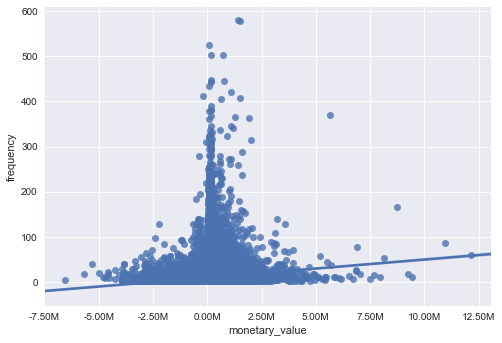

In [126]:
# Method 1 : 
# plt.scatter(x=data['monetary_value'],y=data['frequency'])
# plt.show()

# # Method 2 :
g = sns.regplot(x='monetary_value', y='frequency' ,data=data, scatter=True)
g.set_xticklabels(['{:,.2f}'.format(x) + 'M' for x in g.get_xticks()/1000000])

Histogram Revenue

In [139]:
# range_x = pd.Series(range(1,6))*2500000
# plt.hist(data['monetary_value'],bins=50)
# plt.xlabel('monetary_value')
# plt.ylabel('Y')
# # plt.range=pd.Series(range(1,30))*500000
# plt.show()


# sns.histplot(data=data, x="monetary_value")
sns.displot(data['monetary_value'], discrete = True, kde = True)


AttributeError: module 'seaborn' has no attribute 'displot'

Histogram Revenue>0

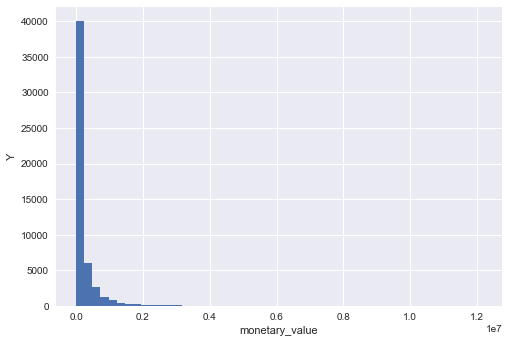

In [120]:
plt.hist(data_revenue_plus['monetary_value'],bins=50)
plt.xlabel('monetary_value')
plt.ylabel('Y')
plt.show()

Histogram Revenue<0

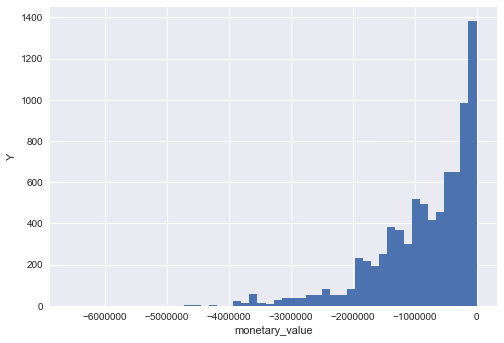

In [121]:
plt.hist(data_revenue_minus['monetary_value'],bins=50)
plt.xlabel('monetary_value')
plt.ylabel('Y')
plt.show()

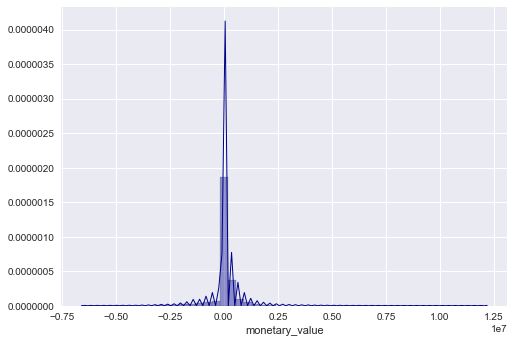

In [122]:
sns.distplot(data['monetary_value'], hist=True, kde=True, 
             bins=50, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})

Export to excel/csv

In [ ]:
data_revenue_0.to_excel('Data Revenue 0.xlsx',index=False)

In [132]:
one_to_hundred = pd.Series(range(1,30))*500000
one_to_hundred.head()

0     500000
1    1000000
2    1500000
3    2000000
4    2500000
dtype: int64